<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/backpropagation_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple start


In [355]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to explain Backpropagation
def f(x):
  """
  6x^2 - 10
  """
  return 2*x**3 - 10*x + 3

f(3.0)

27.0

- What is the derivate of this function at any given point?

  - What is the derivate telling me about the function?
  - Derivate: if I have a value a and increase it by h, how much does the function change?
  - This change is the slope of the function. And if it is positive it goes up, if it is positive it goes down!

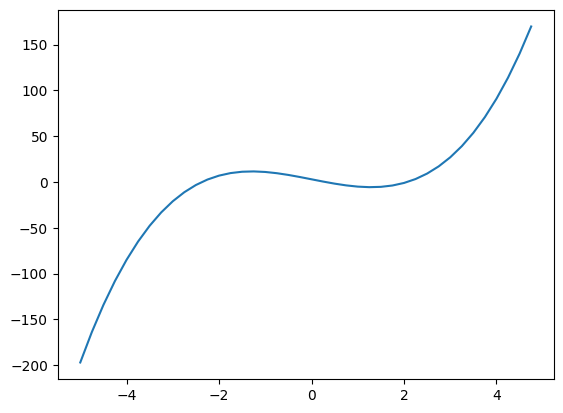

In [356]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

- For the above function, looking at any value in bigger than 2 for x, I would expect the Derivate to be positive!
- Lets test it!

In [357]:
def derivate (x, h):
  """
  Dividing by h gives you the rate of change.
  f(x + h) - f(x) --> Difference between to points.
  /h --> Rate of change, which is the comparision between two things that
  change at the same time.

  The change of rate established a connection.
  """
  return (f(x + h) - f(x))/h

# Numerical approximation of the slope, h has to be close to 0 for better resutls
print(derivate(2, 0.001))
print(derivate(0, 0.001))
print(derivate(-4, 0.001))

14.012001999997636
-9.999998000000065
85.97600199999533


# Add complexity
- What are the derivate in terms of a, b, and c?

In [358]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [359]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c
derivate = (d2 - d1)/h
# Increasing a decreses d, because you multiply b by a.
# b is negative here -> decrease.
print('d1, ', d1)
print('d2, ', d2)
print('Slope ',  derivate)

d1,  4.0
d2,  3.999699999999999
Slope  -3.000000000010772


In [411]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self._backward = lambda: None
    self.grad = 0.0
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    out = Value(self.data - other.data, (self, other), "-")
    return out

  def tanh(self):
    t = math.tanh(self.data)
    out = Value(t,  (self, ), "tanh")

    def _backward():
      self.grad = (1 - t ** 2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [361]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
# same as c = a + b
c = a.__add__(b)
c.label = 'c'

In [362]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

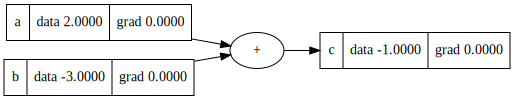

In [363]:
draw_dot(c)


- Next up!
Calculate the Gradient, or spelled out:
The Derivate of each node in terms of final output!

- Zoom out:
1. We have data that is fixed and not fixed.
2. We use a loss function of what we are aiming for, it can be simple like a mean squared error, or more complex.
3. We then adjust the non fixed data, by caluclating the gradient in terms of loss.

In [364]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

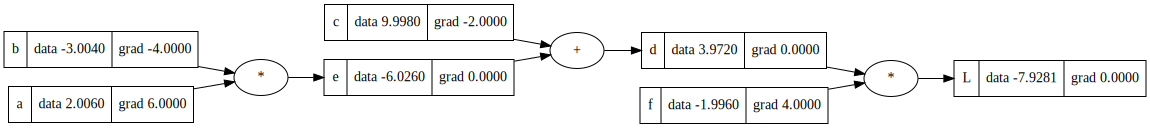

In [375]:
draw_dot(L)

"if we wiggle c, how does that impact L?"

dL/dc
- Numerator(thing on top) the thing taht changes
- Demoniator(thing on bottom) the thing that I am changing

- local derivate
dd/dc ?
d = c + e

- Deriving it form the basics
1. (f(x+h) - f(x))/h
2. (c + h + e - c - e) / h
3. e + h / h
4. e

- But what about the influnce of c for L?

WANT:
dL/dc = (dL / dd ) * (dd/dc)

KNOW:
dL / dd
dd/ dc

In [366]:
# Backwardpass by hand
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -3.0 * e.grad
b.grad = 2.0 * e.grad

In [367]:
# Adjust the leaf nodes
print(f"a before applying Gradient with learning rate: {a.data}")
a.data += 0.001 * a.grad
print(f"a after applying Gradient with learning rate: {a.data}")
b.data += 0.001 * b.grad
c.data += 0.001 * c.grad
f.data += 0.001 * f.grad

# Rerun the forward pass
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
L

# Single step finished.
# Calculate the gradient again and do it over and over again!

a before applying Gradient with learning rate: 2.0
a after applying Gradient with learning rate: 2.006


Value(data=-7.928064095999999)

In [368]:
# Backwardpass by hand
def lol():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0 + h, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()


-4.000000000008441


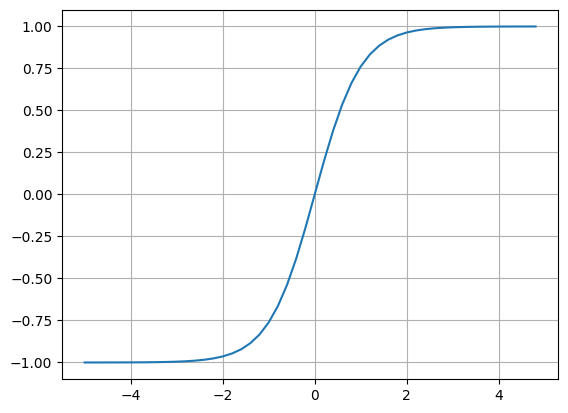

In [369]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [370]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

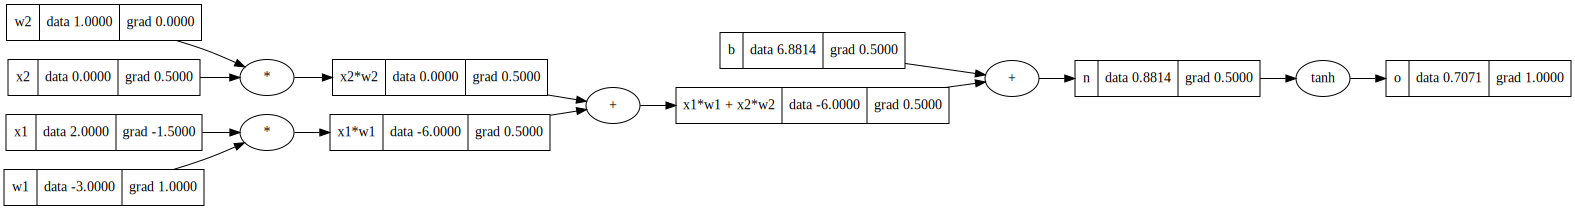

In [380]:
draw_dot(o)

In [379]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

- do/do = 1.0
- do/dn = 1 - tanh(n) ** 2

In [386]:
# Gradient inline check
def lol():
  h = 0.0001

  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')
  # weights w1,w2
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')
  # bias of the neuron
  b = Value(6.8813735870195432, label='b')
  # x1*w1 + x2*w2 + b
  x1w1 = x1*w1; x1w1.label = 'x1*w1'
  x2w2 = x2*w2; x2w2.label = 'x2*w2'
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
  n = x1w1x2w2 + b; n.label = 'n'
  o = n.tanh(); o.label = 'o'
  L1 = o.data

  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')
  # weights w1,w2
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')
  # bias of the neuron
  b = Value(6.8813735870195432, label='b')
  # x1*w1 + x2*w2 + b
  x1w1 = x1*w1; x1w1.label = 'x1*w1'
  x2w2 = x2*w2; x2w2.label = 'x2*w2'
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
  n = x1w1x2w2 + b; n.label = 'n'
  o = n.tanh(); o.label = 'o'
  L2 = o.data

  print((L2 - L1) / h)

lol()


0.0


In [417]:
# Use newly implemented backward

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

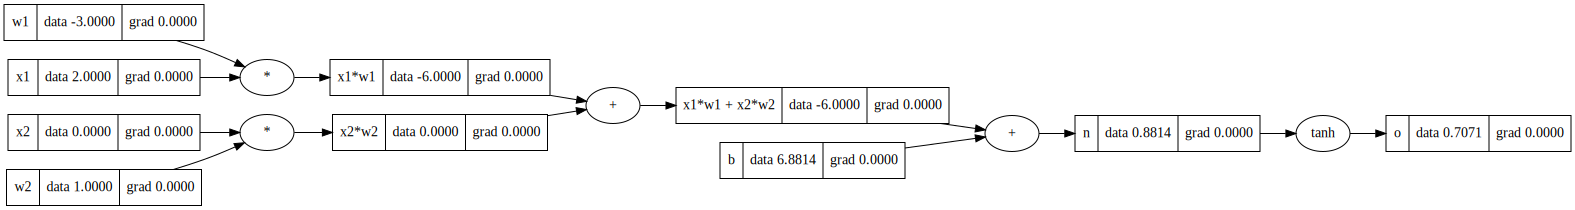

In [418]:
draw_dot(o)

In [419]:
# Base case
o.backward()

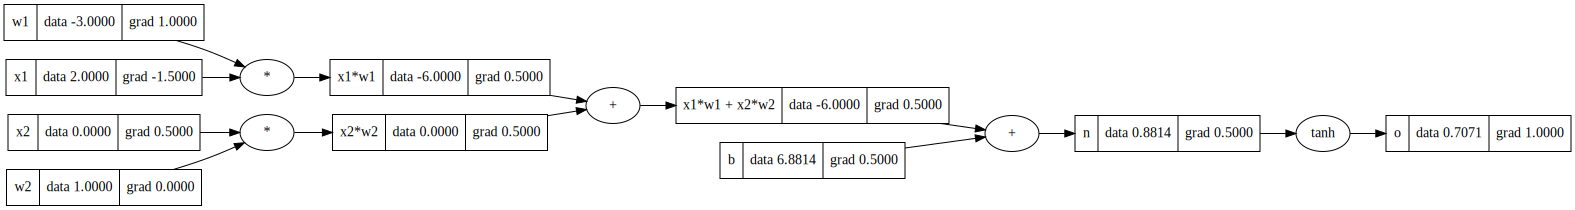

In [420]:
draw_dot(o)